# FINM 36700 Mark Hendricks
## Autumn 2024

# Homework #8

### Long-Term Capital Management, L.P. (A) [HBS 9-200-007]

## 1. Conceptual Issues for LTCM

Discuss these questions briefly, based on the info in the case. No need to quantitatively answer these questions.

1. Describe LTCM’s investment strategy with regard to the following aspects:

* Securities traded
* Trading frequency
* Skewness (Do they seek many small wins or a few big hits?)
* Forecasting (What is behind their selection of trades?)

2. What are LTCM’s biggest advantages over its competitors?

3. The case discusses four types of funding risk facing LTCM:
The case discusses ways in which LTCM manages each of these risks. Briefly discuss them.

* Collateral haircuts
* Repo maturity
* Equity redemption
* Loan access

The case discusses specific ways in which LTCM manages each of these risks. Briefly discuss
them.

4. LTCM is largely in the business of selling liquidity and volatility. Describe how LTCM accounts for liquidity risk in their quantitative measurements.

5. Is leverage risk currently a concern for LTCM?

6. Many strategies of LTCM rely on converging spreads. LTCM feels that these are almost win/win situations because of the fact that if the spread converges, they make money. If it diverges, the trade becomes even more attractive, as convergence is still expected at a future date. 
What is the risk in these convergence trades?


## 2. LTCM Risk Decomposition

- On Canvas, find the data file, “ltcm exhibits data.xlsx.” Get the gross and net (total) returns of LTCM from “Exhibit 2.”
- Get the returns on SPY as well as the risk-free rate from the file, “gmo analysis data.”


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew,kurtosis,norm
import statsmodels.api as sm

path = "../../data/ltcm_exhibits_data.xlsx"
ltcm_exhibits_data = pd.read_excel(path, sheet_name="Exhibit 2", index_col=0, header=2).dropna()
ltcm_exhibits_data.index = pd.to_datetime(ltcm_exhibits_data.index)
ltcm_exhibits_data.columns = ["fund_capital", "gross_performance", "net_performance", "index_net_performance"]


In [3]:
rf_rate.index

NameError: name 'rf_rate' is not defined

In [ ]:
ltcm_exhibits_data.index

DatetimeIndex(['1994-03-01', '1994-04-01', '1994-05-01', '1994-06-01',
               '1994-07-01', '1994-08-01', '1994-09-01', '1994-10-01',
               '1994-11-01', '1994-12-01', '1995-01-01', '1995-02-01',
               '1995-03-01', '1995-04-01', '1995-05-01', '1995-06-01',
               '1995-07-01', '1995-08-01', '1995-09-01', '1995-10-01',
               '1995-11-01', '1995-12-01', '1996-01-01', '1996-02-01',
               '1996-03-01', '1996-04-01', '1996-05-01', '1996-06-01',
               '1996-07-01', '1996-08-01', '1996-09-01', '1996-10-01',
               '1996-11-01', '1996-12-01', '1997-01-01', '1997-02-01',
               '1997-03-01', '1997-04-01', '1997-05-01', '1997-06-01',
               '1997-07-01', '1997-08-01', '1997-09-01', '1997-10-01',
               '1997-11-01', '1997-12-01', '1998-01-01', '1998-02-01',
               '1998-03-01', '1998-04-01', '1998-05-01', '1998-06-01',
               '1998-07-01'],
              dtype='datetime64[ns]', freq=None

In [ ]:
def get_metric_returns(returns, weights=[], adj_factor=12, VaR_q=5):


    # If weights are provided, compute the weighted returns
    if len(weights) == 0:
        port_metrics = returns.copy()
    else:
        port_metrics = returns @ weights
        port_metrics = pd.DataFrame(port_metrics, columns=['Portfolio'])

    # Initialize the result DataFrame
    result = pd.DataFrame()

    # Compute Mean, Volatility, Sharpe Ratio, Skew, Excess Kurtosis
    if len(weights) == 0:
        port_metrics_r = pd.DataFrame({
            "Mean": port_metrics.mean() * adj_factor,
            "Volatility": port_metrics.std() * np.sqrt(adj_factor)
        })
        port_metrics_r["Sharpe_Ratio"] = (port_metrics.mean() / port_metrics.std()) * np.sqrt(adj_factor)
        port_metrics_r["Skew"] = port_metrics.apply(skew)
        port_metrics_r["Excess Kurtosis"] = port_metrics.apply(kurtosis, fisher=True, bias=False)
    else:
        asset = 'Portfolio'
        port_metrics_r = pd.DataFrame({
            "Mean": [port_metrics[asset].mean() * adj_factor],
            "Volatility": [port_metrics[asset].std() * np.sqrt(adj_factor)]
        }, index=[asset])
        port_metrics_r["Sharpe_Ratio"] = (port_metrics[asset].mean() / port_metrics[asset].std()) * np.sqrt(adj_factor)
        port_metrics_r["Skew"] = skew(port_metrics[asset])
        port_metrics_r["Excess Kurtosis"] = kurtosis(port_metrics[asset], fisher=True, bias=False)

    # Compute VaR, CVaR, Max Drawdown, and related metrics
    for asset in port_metrics.columns:
        data_aux = port_metrics[[asset]].copy()
        VaR = np.percentile(sorted(data_aux.values.flatten()), q=VaR_q)
        CVaR = data_aux[data_aux[asset] <= VaR].mean().values[0]

        data_aux_acum_return = (data_aux + 1).cumprod()
        data_aux_max_cum_return = data_aux_acum_return.cummax()
        data_aux_drawdown = ((data_aux_acum_return - data_aux_max_cum_return) / data_aux_max_cum_return)
        max_drawdown = data_aux_drawdown.min().values[0]
        max_drawdown_date = data_aux_drawdown.idxmin().values[0]
        peak_idx = data_aux_max_cum_return.idxmax().values[0]
        recovery_data = data_aux_drawdown[data_aux_drawdown.index >= max_drawdown_date]
        recovery_idx = recovery_data[recovery_data[asset] >= -0.00001].first_valid_index()
        duration = (recovery_idx - max_drawdown_date).days if recovery_idx else np.nan

        aux_result = pd.DataFrame(
            [[VaR, CVaR, max_drawdown, max_drawdown_date, peak_idx, recovery_idx, duration]],
            columns=["VaR", "CVaR", "Max Drawdown", "Bottom", "Peak", "Recovery", "Duration (days)"],
            index=[asset]
        )
        result = pd.concat([result, aux_result], axis=0)

    # Merge the two sets of metrics
    metrics = pd.merge(port_metrics_r, result, left_index=True, right_index=True, how="left")
    return metrics


In [4]:
ltcm = pd.read_excel("../../data/ltcm_exhibits_data.xlsx", sheet_name="Exhibit 2",skiprows=2, index_col=0, parse_dates=[0]).iloc[:-4, :]
ltcm.index.name = 'Date'
ltcm.index = pd.to_datetime(ltcm.index)
ltcm.index.strftime('%Y-%m-%d')
ltcm.head()

,Fund Capital ($billions),Gross Monthly Performancea,Net Monthly Performanceb,Index of Net Performance
Date,,,,
NaT,NaN,NaN,NaN,1.00
1994-03-01,1.1,-0.011,-0.013,0.99
1994-04-01,1.1,0.014,0.008,1.00
1994-05-01,1.2,0.068,0.053,1.05
1994-06-01,1.2,-0.039,-0.029,1.02


In [5]:
rf= pd.read_excel("../../data/gmo_analysis_data.xlsx", sheet_name="risk-free rate",index_col=0, parse_dates=[0])/12
rf.index.name="Date"
rf.index = rf.index.to_period('M').to_timestamp('D', how='start')
rf.head()

,TBill 3M
Date,
1989-12-01,0.006367
1990-01-01,0.006450
1990-02-01,0.006583
1990-03-01,0.006475
1990-04-01,0.006450


In [6]:

SPY= pd.read_excel("../../data/gmo_analysis_data.xlsx", sheet_name="total returns",index_col=0, parse_dates=[0]).iloc[:,[0]]
SPY.index = SPY.index.to_period('M').to_timestamp('D', how='start')
SPY.head()

,SPY
date,
1993-02-01,0.010667
1993-03-01,0.022408
1993-04-01,-0.025590
1993-05-01,0.026970
1993-06-01,0.003667


In [7]:
join_data=pd.concat([SPY, rf, ltcm[["Gross Monthly Performancea", "Net Monthly Performanceb"]]], axis=1 ).dropna()
join_data["Gross Monthly Performancea"]=join_data["Gross Monthly Performancea"].subtract(join_data["TBill 3M"])
join_data["Net Monthly Performanceb"]=join_data["Net Monthly Performanceb"].subtract(join_data["TBill 3M"])
join_data["SPY"]=join_data["SPY"].subtract(join_data["TBill 3M"])

1. Summary stats

    (a) For both the gross and net series of LTCM excess returns, report the mean, volatility, and Sharpe ratios. (Annualize them.)

    (b) Report the skewness, kurtosis, and (historic) VaR(.05).

    (c) Comment on how these stats compare to SPY and other assets we have seen. How much do they differ between gross and net?


In [8]:
get_metric_returns(join_data[["Gross Monthly Performancea", "Net Monthly Performanceb", "SPY"]], adj_factor=12, VaR_q=5)

NameError: name 'get_metric_returns' is not defined

*Answer* 

As we can see, the *Gross Monthly Performance* exceeds the SPY's return by 0.068 points, with similar volatility, resulting in a better Sharpe Ratio for *Gross Monthly Performance*. However, *Net Monthly Performance* shows a lower return compared to the SPY and similar volatilities, implying that the SPY's Sharpe Ratio is more favorable.  

Regarding the VaR(0.05), a higher risk is observed in the SPY. The kurtosis indicates a greater risk of extreme values in *LTCM Net* compared to the SPY. Additionally, the *skewness* is higher in *LTCM Net*.

2. Using the series of net LTCM excess returns, denoted $r^{LTCM}$, estimate the following regression:

$$
{r_t}^{LTCM} = \alpha + \beta_m {r_t}^{m} + \epsilon_t
$$

(a) Report $\alpha$ and $\beta_m$. Report the $R^2$ stat. 

(b) From the regression, does LTCM appear to be a “closet indexer”?
    
(c) From the regression, does LTCM appear to deliver excess returns beyond the risk premium we expect from market exposure?

In [ ]:
Y = join_data[["Net Monthly Performanceb"]]
X = join_data["SPY"]
X = sm.add_constant(X)
model = sm.OLS(Y,X).fit()
adj = 12
inter = model.params.values[0]*adj
betas = model.params.values[1]
rsquare = model.rsquared

metrics =  pd.DataFrame([[inter, betas, rsquare]], columns=["Intercept", "Beta", "R^2"], index=["Net Monthly Performance"])


In [ ]:
metrics

,Intercept,Beta,R^2
Net Monthly Performance,0.132603,0.137101,0.019097


3. Let's check for non-linear market exposure. Run the following regression on LTCM's net excess returns:

$
{r_t}^{LTCM} = \alpha + \beta_1 {r_t}^{m} + \beta_2 ({r_t}^{m})^2 + \epsilon_t $

(a) Report $\beta_1$, $\beta_2$, and $R^2$.

(b) Does the quadratic market factor do much to increase the overall LTCM variation explained by the market?

(c) From the regression evidence, does LTCM market exposure behave as if it is long market options or short market options? 

(d) Should we describe LTCM as being positively or negatively exposed to market volatility? 

In [ ]:
Y = join_data[["Net Monthly Performanceb"]]
X = join_data["SPY"]
X = sm.add_constant(X)
X["SPY_squared"] = X["SPY"]**2
model = sm.OLS(Y,X).fit()
adj = 12
inter = model.params.values[0]*adj
betas1 = model.params.values[1]
betas2 = model.params.values[2]

rsquare = model.rsquared

metrics =  pd.DataFrame([[inter, betas1, betas2, rsquare]], columns=["Intercept", "Beta SPY", "Beta SPY Squared", "R^2"], index=["Net Monthly Performance"])


In [ ]:
metrics

,Intercept,Beta SPY,Beta SPY Squared,R^2
Net Monthly Performance,0.156279,0.167321,-1.928874,0.024539


4. Let's try to pinpoint the nature of LTCM's nonlinear exposure. Does it come more from exposure to up-markets or down-markets? Run the following regression on LTCM's net excess returns

$$
{r_t}^{LTCM} = \alpha + \beta{r_t}^{m} + \beta_u \max({r_t}^{m} - k_1, 0) + \beta_d \max(k_2 - {r_t}^{m}, 0) + \epsilon_t
$$
where k1 = .03 and k2 = −.03. (This is roughly one standard deviation of  ̃${r_t}^{m}$)

(a) Report $\beta$, $\beta_u$, $\beta_d$, and $R^2$.

(b) Is LTCM long or short the call-like factor? And the put-like factor?


(c) Which factor moves LTCM more, the call-like factor, or the put-like factor?


(d) In the previous problem, you commented on whether LTCM is positively or negatively exposed to marked volatility. Using this current regression, does this volatility exposure come more from being long the market's upside? Short the market's downside? Something else? 

## 3. The FX Carry Trade

Find an Excel data file, "data/fx_rf_data.xlsx". The file has two sets of data: 
* "risk-free rates” - daily quotes of annualized risk-free rates across currencies.
* “exchange rates” - daily quotes of spot FX rates expressed as direct quotes to the USD

Data processing: 

* For risk-free rate data, $r_{t,t+1}^{f,i}$, the rate is known and reported in the data at time t. Namely, any given date t in the data file is reporting both $S_{t}^{i}$ and $r_{t,t+1}^{f,i}$.
* The theory says to use log risk-free rates. You have the risk-free rate in levels: use the following equation to convert them:
$$
r_{t,t+1}^{f,i} = ln(1+r_{t,t+1}^{f,i})
$$
* The theory says to use log spot FX prices. You have the FX prices in levels, so directly take their logarithims:
$$
s_{t}^{i} = ln(S_{t}^{i})
$$


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew,kurtosis,norm
import statsmodels.api as sm

path = "../../data/fx_rf_data.xlsx"
risk_free_rate = pd.read_excel(path, sheet_name="risk-free rates", index_col=0)
exchange_rates = pd.read_excel(path, sheet_name="exchange rates", index_col=0)

In [27]:
risk_free_rate = np.log(1 + risk_free_rate/252) # Daily risk-free rate
exchange_rates = np.log(exchange_rates) # Daily exchange rates
risk_free_rate = risk_free_rate[risk_free_rate.index.isin(exchange_rates.index)]

In [28]:
len(risk_free_rate)

4393

#### 3.1 Static Carry Trade

Define the log return of holding the foreign currency using log values of the risk-free rate and log values of the FX rates:
$$
r_{t+1}^{i} = s_{t+1}^{i} - s_{t}^{i} + r_{t,t+1}^{f,i}
$$

Then the excess log return relative to USD, is expressed as
$$
r_{t+1}^{i} = s_{t+1}^{i} - s_{t}^{i} + r_{t,t+1}^{f,i} - r_{t,t+1}^{f,USD} 
$$

For each foreign currency, i, calculate the excess log return series, $r_{t+1}^{~}$. Report the following stats, (based on the excess log returns.) Annualize them.


1. Mean
2. Volatility
3. Sharpe ratio

What differences do you see across currencies?


In [29]:
excess_log_returns = pd.DataFrame()
fx_spread = pd.DataFrame()
rf_spread = pd.DataFrame()  

for currency in exchange_rates.columns:
    excess_log_returns[currency] = exchange_rates[currency] - exchange_rates[currency].shift(1) + risk_free_rate[currency].shift(1) - risk_free_rate["USD"].shift(1)
    fx_spread[currency] = exchange_rates[currency] - exchange_rates[currency].shift(1)
    rf_spread[currency] = risk_free_rate["USD"].shift(1) - risk_free_rate[currency].shift(1) 

In [30]:
rf_spread

,JPY,EUR,GBP,MXN,CHF
date,,,,,
2008-01-01,NaN,NaN,NaN,NaN,NaN
2008-01-02,0.000156,0.000006,-0.000052,-0.000123,0.000093
2008-01-03,0.000146,0.000022,-0.000052,-0.000133,0.000083
2008-01-04,0.000153,0.000016,-0.000050,-0.000125,0.000087
2008-01-07,0.000148,0.000006,-0.000051,-0.000130,0.000084
...,...,...,...,...,...
2024-10-25,0.000184,0.000068,-0.000004,-0.000224,0.000159
2024-10-28,0.000184,0.000066,-0.000003,-0.000223,0.000160
2024-10-29,0.000184,0.000066,-0.000007,-0.000224,0.000160


In [31]:
fx_spread

,JPY,EUR,GBP,MXN,CHF
date,,,,,
2008-01-01,NaN,NaN,NaN,NaN,NaN
2008-01-02,0.017925,0.008394,-0.002823,-0.002289,0.012277
2008-01-03,0.003175,0.002376,-0.004960,0.002725,0.007694
2008-01-04,0.006646,-0.000475,0.001521,-0.003598,0.002219
2008-01-07,-0.005444,-0.003193,-0.001825,0.002400,-0.007231
...,...,...,...,...,...
2024-10-25,-0.003194,-0.002960,-0.001002,-0.008954,-0.001299
2024-10-28,-0.006265,0.001481,0.000771,-0.002802,0.001646
2024-10-29,-0.000460,0.000647,0.003309,-0.001003,-0.002166


<Axes: xlabel='date'>

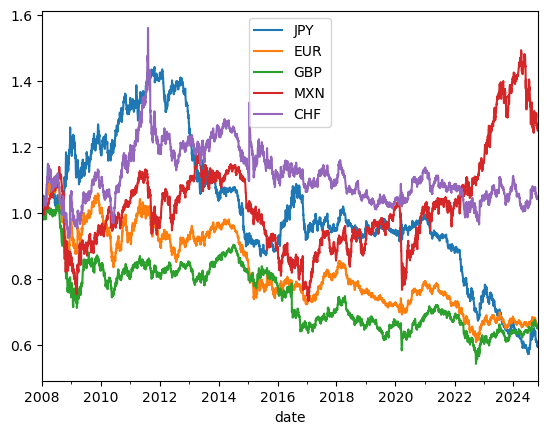

In [12]:
np.exp(excess_log_returns.cumsum()).plot()

In [18]:
get_metric_returns(excess_log_returns.dropna(), adj_factor=252, VaR_q=5)

NameError: name 'get_metric_returns' is not defined

*Answer* : 

The key differences across the currencies are:

* Mean Excess Returns: MXN and CHF have positive mean excess returns, while JPY, EUR, and GBP have negative mean excess returns.
* Volatility: MXN exhibits the highest volatility, indicating higher risk.
* Sharpe Ratio: MXN has the highest Sharpe Ratio (approximately 0.10), suggesting it offers the best risk-adjusted returns among the currencies analyzed. CHF has a marginally positive Sharpe Ratio, while the others are negative.

These differences suggest that `MXN` provided better compensation for risk compared to the other currencies during the sample period.

#### 3.2 Implications for UIP

1. Do any of these stats contradict the (log version) of Uncovered Interest Parity (UIP)?

    *Answer*: Yes, the statistics contradict the log version of Uncovered Interest Parity (UIP). According to UIP, the expected excess return from holding foreign currency should be zero because any interest rate differential should be offset by expected movements in exchange rates. However, the calculated mean excess returns are significantly different from zero for several currencies (e.g., MXN and CHF have positive mean excess returns, while JPY, EUR, and GBP have negative ones), suggesting that UIP does not hold empirically in this sample.

2. A long position in which foreign currency offered the best Sharpe ratio over the sample?

    *Answer*: TThe MXN (Mexican Peso) offered the best Sharpe Ratio of approximately 0.10 over the sample, indicating it provided the best risk-adjusted excess returns among the currencies analyzed.
 
3. Are there any foreign currencies for which a long position earned a negative excess return (in USD) over the sample? 

    *Answer*: Yes, long positions in JPY (Japanese Yen), EUR (Euro), and GBP (British Pound) resulted in negative mean excess returns when measured in USD over the sample period.

#### 3.3 Predicting FX

For each foreign currency, test whether interest-rate differentials can predict growth in the foreign-exchange rate. Do this by estimating the following forecasting regression:

$$
s_{t+1}^{i} - s_{t}^{} = \alpha_i + \beta_i
\left(
r_{t,t+1}^{f,USD}  - r_{t,t+1}^{f,i} 
\right)
+ \epsilon_{t+1}^{i}
$$

where $r^{f,i}$ denotes the risk-free rate of currency $i$, and $s_i$ denotes the FX rate for currency $i$.
Again, note that both $r_{t,t+1}^{f,USD}$ and $s_t$ are determined at time $t$.

In [34]:
regression_DB = fx_spread.merge(rf_spread, left_index=True, right_index=True, suffixes=('_fx', '_rf'))

In [38]:
metrics = pd.DataFrame()
adj = 252
for currency in fx_spread.columns:
    Y = regression_DB[[currency+"_fx"]]
    X = regression_DB[currency+ "_rf"]
    X = sm.add_constant(X)
    model = sm.OLS(Y,X, missing = "drop").fit()
    inter = model.params.values[0]*adj
    betas = model.params.values[1]
    rsquare = model.rsquared

    metrics = pd.concat([metrics, pd.DataFrame([[inter, betas, rsquare]], columns=["Intercept", "Beta", "R^2"], index=[currency])], axis=0)



1. Make a table with columns corresponding to a different currency regression.  Report the regression estimates $\alpha_i$ and $\beta_i$ in the first two rows.  Report the $R^2$ stat in the third row.

In [39]:
display(metrics)

,Intercept,Beta,R^2
JPY,-0.021877,0.351755,0.000013
EUR,-0.031513,2.160192,0.000298
GBP,-0.025228,6.810272,0.001537
MXN,-0.073561,-0.808766,0.000020
CHF,0.003703,0.906945,0.000050


2. Suppose the foreign risk-free rate increases relative to the US rate.

    (a) For which foreign currencies would we predict a relative strengthening of the USD in the following period?

    *Answer* : For currencies with positive betas (JPY, EUR, GBP, and CHF), an increase in the foreign risk-free rate relative to the US rate would lead to a decrease in the expected change in the exchange rate . This implies that the foreign currency is expected to depreciate against the USD, leading to a relative strengthening of the USD.

    (b) For which currencies would we predict relative weakening of the USD in the following period?

    *Answer* : For the MXN, which has a negative beta, an increase in the foreign risk-free rate relative to the US rate would lead to an increase in the expected change in the exchange rate. This means the USD is expected to depreciate against the MXN, resulting in a relative weakening of the USD.

    (c) This FX predictability is strongest in the case of which foreign currency?

    *Answer* : Although the values are very low for all currencies, indicating weak explanatory power, the GBP has the highest (approximately 0.0015), suggesting that the interest rate differential explains slightly more of the variation in the exchange rate changes for the GBP compared to the other currencies.

#### 3.4 The Dynamic Carry Trade

Use this to write $E\left[\tilde{r}_{i,t+1}\right]$ as a function of the interest-rate differential as well as $\alpha$ and $\beta$ from this FX regression:
$$
E\left[s_{t+1} - s_t\right] = \alpha + \beta
\left(
r_{t,t+1}^{f,USD} - r_{t,t+1}^{f,i}
\right)
$$

Then use the definition of excess (log) returns on FX:

$$
\tilde{r}_{i,t+1} = s_{t+1} - s_t -
\left(
r_{t,t+1}^{f,USD} - r_{t,t+1}^{f,i}
\right)
$$

Rearranging, this implies the following forecast for excess log returns:
$$
E\left[\tilde{r}_{i,t+1}\right] = \alpha + (\beta - 1)
\left(
r_{t,t+1}^{f,USD} - r_{t,t+1}^{f,i}
\right)
$$

1. Use your regression estimates from Problem 3 along with the formula above to calculate the fraction of months for which the estimated FX risk premium is positive. That is, for each $i$, calculate how often in the time-series we have

$$
E\left[\tilde{r}_{i,t+1}\right] > 0
$$

In [40]:
expected_fx_premium = pd.DataFrame()
for currency in fx_spread.columns:
    expected_fx_premium[currency] = rf_spread[currency]*(metrics.loc[currency, "Beta"]-1) + metrics.loc[currency, "Intercept"]/adj 

In [41]:
expected_fx_premium.describe()

,JPY,EUR,GBP,MXN,CHF
count,4392.000000,4392.000000,4392.000000,4392.000000,4392.000000
mean,-0.000117,-0.000094,-0.000099,0.000052,0.000010
std,0.000042,0.000053,0.000202,0.000082,0.000005
min,-0.000234,-0.000269,-0.001080,-0.000096,-0.000005
25%,-0.000133,-0.000126,-0.000169,0.000004,0.000006
50%,-0.000092,-0.000097,-0.000117,0.000023,0.000012
75%,-0.000089,-0.000052,-0.000002,0.000126,0.000014
max,-0.000084,0.000045,0.000481,0.000293,0.000022


In [42]:
positive_premium_counts = (expected_fx_premium > 0).sum()
print(positive_premium_counts/len(expected_fx_premium))

JPY    0.000000
EUR    0.037787
GBP    0.248805
MXN    0.760528
CHF    0.964944
dtype: float64


2. Which currencies most consistently have a positive FX risk premium? And for which currencies does the FX risk premium most often go negative?

*Answer* : `CHF` always have a positive expected return, but very close to zero. On the other hand, `JPY` never showed a day with a positive expected return 


3. Explain how we could use these conditional risk premia to improve the static carry trade returns calculated in Problem 1.

*Answer* : To improve the static carry trade returns, we can employ a dynamic strategy that adjusts positions based on the estimated FX risk premia:

Long Positions: Focus on currencies like the MXN, which has a positive expected FX risk premium in a significant fraction of periods. By taking long positions when the expected premium is positive, we can capitalize on periods with higher expected returns.

Short Positions: For currencies like the JPY, which consistently show a negative expected FX risk premium, we can take short positions to benefit from the expected depreciation of these currencies against the USD.

Dynamic Allocation: By adjusting our positions based on the sign and magnitude of the expected FX risk premium, we can potentially enhance returns compared to a static carry trade strategy that doesn't consider time-varying risk premia.